## Topics
1. Review of model evaluation
2. Model evaluation procedures
3. Model evaluation metrics
4. Classification accuracy
5. Confusion matrix
6. Metrics computed from a confusion matrix
7. Adjusting the classification threshold
8. Receiver Operating Characteristic (ROC) Curves
9. Area Under the Curve (AUC)
10. Confusion Matrix Resources
11. ROC and AUC Resources
12. Other Resources

_This tutorial is derived from Data School's Machine Learning with scikit-learn tutorial. I added my own notes so anyone, including myself, can refer to this tutorial without watching the videos._

### 1. Review of model evaluation

- Need a way to choose between models: different model types, tuning parameters, and features
- Use a **model evaluation procedure** to estimate how well a model will generalize to out-of-sample data
- Requires a **model evaluation metric** to quantify the model performance

### 2. Model evaluation procedures

1. **Training and testing on the same data**
    - Rewards overly complex models that "overfit" the training data and won't necessarily generalize
    
2. **Train/test split**
    - Split the dataset into two pieces, so that the model can be trained and tested on different data
    - Better estimate of out-of-sample performance, but still a "high variance" estimate
    - Useful due to its speed, simplicity, and flexibility
3. **K-fold cross-validation**
    - Systematically create "K" train/test splits and average the results together
    - Even better estimate of out-of-sample performance
    - Runs "K" times slower than train/test split

### 3. Model evaluation metrics

- **Regression problems:** Mean Absolute Error, Mean Squared Error, Root Mean Squared Error
- **Classification problems:** Classification accuracy
    - There are many more metrics, and we will discuss them today

### 4. Classification accuracy

[Pima Indian Diabetes dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) from the UCI Machine Learning Repository

In [1]:
# read the data into a Pandas DataFrame
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'

col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age','label']

pima = pd.read_csv(url, header=None, names=col_names)

In [2]:
# print the first 5 rows of data from the dataframe
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- label
    - 1: diabetes
    - 0: no diabetes
- pregnant
    - number of times pregnant

**Question:** Can we predict the diabetes status of a patient given their health measurements?

In [3]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']

# X is a matrix, hence we use [] to access the features we want in feature_cols
X = pima[feature_cols]

# y is a vector, hence we use dot to access 'label'
y = pima.label

In [4]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [7]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.692708333333


Classification accuracy is 69%

**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class
- We must always compare with this

In [8]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    130
1     62
Name: label, dtype: int64

In [9]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
y_test.mean()

0.3229166666666667

32% of the 

In [10]:
# calculate the percentage of zeros
1 - y_test.mean()

0.6770833333333333

In [11]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.6770833333333333

This means that a dumb model that always predicts 0 would be right 68% of the time
- This shows how classification accuracy is not that good as it's close to a dumb model
- It's a good way to know the minimum we should achieve with our models

In [12]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.677083
Name: label, dtype: float64

Comparing the **true** and **predicted** response values

In [13]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('False:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
False: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Conclusion:**

- Classification accuracy is the **easiest classification metric to understand**
- But, it does not tell you the **underlying distribution** of response values
    - We examine by calculating the null accuracy
- And, it does not tell you what **"types" of errors** your classifier is making

### 5. Confusion matrix

Table that describes the performance of a classification model

In [14]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[118  12]
 [ 47  15]]


![Small confusion matrix](images/09_confusion_matrix_1.png)

- Every observation in the testing set is represented in **exactly one box**
- It's a 2x2 matrix because there are **2 response classes**
- The format shown here is **not** universal
    - Take attention to the format when interpreting a confusion matrix

**Basic terminology**

- **True Positives (TP):** we *correctly* predicted that they *do* have diabetes
    - 15
- **True Negatives (TN):** we *correctly* predicted that they *don't* have diabetes
    - 118
- **False Positives (FP):** we *incorrectly* predicted that they *do* have diabetes (a "Type I error")
    - 12
    - Falsely predict positive
    - Type I error
- **False Negatives (FN):** we *incorrectly* predicted that they *don't* have diabetes (a "Type II error")
    - 47
    - Falsely predict negative
    - Type II error

- 0: negative class
- 1: positive class

In [15]:
# print the first 25 true and predicted responses
print('True', y_test.values[0:25])
print('Pred', y_pred_class[0:25])

True [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[118  12]
 [ 47  15]]


![Large confusion matrix](images/09_confusion_matrix_2.png)

### 6. Metrics computed from a confusion matrix

**Classification Accuracy:** Overall, how often is the classifier correct?

In [17]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.692708333333
0.692708333333


**Classification Error:** Overall, how often is the classifier incorrect?

- Also known as "Misclassification Rate"

In [18]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.307291666667
0.307291666667


**Sensitivity:** When the actual value is positive, how often is the prediction correct?
- Something we want to maximize
- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"
- TP / all positive
    - all positive = TP + FN

In [19]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test, y_pred_class))

0.241935483871
0.241935483871


**Specificity:** When the actual value is negative, how often is the prediction correct?
- Something we want to maximize
- How "specific" (or "selective") is the classifier in predicting positive instances?
- TN / all negative 
    - all negative = TN + FP

In [20]:
specificity = TN / (TN + FP)

print(specificity)

0.907692307692


Our classifier
- Highly specific
- Not sensitive

**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [21]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.0923076923077
0.0923076923077


**Precision:** When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?

In [22]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.555555555556
0.555555555556


Many other metrics can be computed: F1 score, Matthews correlation coefficient, etc.

**Conclusion:**

- Confusion matrix gives you a **more complete picture** of how your classifier is performing
- Also allows you to compute various **classification metrics**, and these metrics can guide your model selection

**Which metrics should you focus on?**

- Choice of metric depends on your **business objective**
    - Identify if FP or FN is more important to reduce
    - Choose metric with relevant variable (FP or FN in the equation)
- **Spam filter** (positive class is "spam"): 
    - Optimize for **precision or specificity** 
        - precision
            - false positive as variable
        - specificity
            - false positive as variable
    - Because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- **Fraudulent transaction detector** (positive class is "fraud"): 
    - Optimize for **sensitivity**
        - FN as a variable
    - Because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

###  7. Adjusting the classification threshold

In [23]:
# print the first 10 predicted responses
# 1D array (vector) of binary values (0, 1)
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [24]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10]

array([[ 0.63247571,  0.36752429],
       [ 0.71643656,  0.28356344],
       [ 0.71104114,  0.28895886],
       [ 0.5858938 ,  0.4141062 ],
       [ 0.84103973,  0.15896027],
       [ 0.82934844,  0.17065156],
       [ 0.50110974,  0.49889026],
       [ 0.48658459,  0.51341541],
       [ 0.72321388,  0.27678612],
       [ 0.32810562,  0.67189438]])

- Row: observation
    - Each row, numbers sum to 1
- Column: class
    - 2 reponse classes there 2 columns
        - column 0: predicted probability that each observation is a member of class 0
        - column 1: predicted probability that each observation is a member of class 1 
- Importance of predicted probabilities
    - We can rank observations by probability of diabetes
        - Prioritize contacting those with a higher probability
- predict_proba process
    1. Predicts the probabilities
    2. Choose the class with the highest probability 
- There is a 0.5 classification threshold
    - Class 1 is predicted if probability > 0.5
    - Class 1 is predicted if probability < 0.5

In [25]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([ 0.36752429,  0.28356344,  0.28895886,  0.4141062 ,  0.15896027,
        0.17065156,  0.49889026,  0.51341541,  0.27678612,  0.67189438])

In [26]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [57]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# adjust the font size 
plt.rcParams['font.size'] = 12

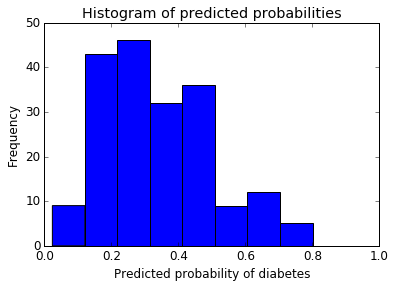

In [58]:
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

- We can see from the third bar
    - About 45% of observations have probability from 0.2 to 0.3
    - Small number of observations with probability > 0.5
    - This is below the threshold of 0.5
    - Most would be predicted "no diabetes" in this case
- Solution
    - **Decrease the threshold** for predicting diabetes
        - **Increase the sensitivity** of the classifier
            - This would increase the number of TP
                - More sensitive to positive instances
                - Example of metal detector
                    - Threshold set to set off alarm for large object but not tiny objects
                    - YES: metal, NO: no metal
                    - We lower the threshold amount of metal to set it off
                    - It is now more sensitive to metal
                    - It will then predict YES more often

In [29]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.3 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_prob, 0.3)[0]

/Users/ritchieng/anaconda3/envs/py3k/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [30]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([ 0.36752429,  0.28356344,  0.28895886,  0.4141062 ,  0.15896027,
        0.17065156,  0.49889026,  0.51341541,  0.27678612,  0.67189438])

In [40]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.])

In [41]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[118  12]
 [ 47  15]]


In [42]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[80 50]
 [16 46]]


- The row totals are the same
- The rows represent actual response values
    - 130 values top row
    - 62 values bottom row
- Observations from the left column moving to the right column because we will have more TP and FP 

In [46]:
# sensitivity has increased (used to be 0.24)
print (46 / float(46 + 16))

0.7419354838709677


In [44]:
# specificity has decreased (used to be 0.91)
print(80 / float(80 + 50))

0.6153846153846154


**Conclusion:**

- **Threshold of 0.5** is used by default (for binary problems) to convert predicted probabilities into class predictions
- Threshold can be **adjusted** to increase sensitivity or specificity
- Sensitivity and specificity have an **inverse relationship**
    - Increasing one would always decrease the other
- Adjusting the threshold should be one of the last step you do in the model-building process
    - The most important steps are 
        - Building the models
        - Selecting the best model

### 8. Receiver Operating Characteristic (ROC) Curves 

**Question:** Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

**Answer:** Plot the ROC curve.
- Receiver Operating Characteristic (ROC)

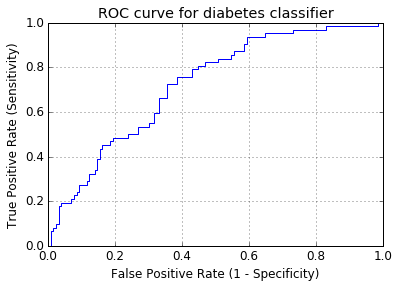

In [59]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

- ROC curve can help you to **choose a threshold** that balances sensitivity and specificity in a way that makes sense for your particular context
- You can't actually **see the thresholds** used to generate the curve on the ROC curve itself

In [63]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [64]:
evaluate_threshold(0.5)

Sensitivity: 0.241935483871
Specificity: 0.907692307692


In [65]:
evaluate_threshold(0.3)

Sensitivity: 0.725806451613
Specificity: 0.615384615385


### 9. AUC
AUC is the **percentage** of the ROC plot that is **underneath the curve**:

In [67]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.724565756824


- AUC is useful as a **single number summary** of classifier performance
- Higher value = better classifier
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation
- AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
    - Fraud case
        - Null accuracy almost 99%
        - AUC is useful here

In [68]:
# calculate cross-validated AUC
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.73782336182336183

Use both of these whenever possible

1. **Confusion matrix advantages:**

    - Allows you to calculate a **variety of metrics**
    - Useful for **multi-class problems** (more than two response classes)

2. **ROC/AUC advantages:**

    - Does not require you to **set a classification threshold**
    - Still useful when there is **high class imbalance**

### 10. Confusion Matrix Resources

- Blog post: [Simple guide to confusion matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by me
- Videos: [Intuitive sensitivity and specificity](https://www.youtube.com/watch?v=U4_3fditnWg) (9 minutes) and [The tradeoff between sensitivity and specificity](https://www.youtube.com/watch?v=vtYDyGGeQyo) (13 minutes) by Rahul Patwari
- Notebook: [How to calculate "expected value"](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb) from a confusion matrix by treating it as a cost-benefit matrix (by Ed Podojil)
- Graphic: How [classification threshold](https://media.amazonwebservices.com/blog/2015/ml_adjust_model_1.png) affects different evaluation metrics (from a [blog post](https://aws.amazon.com/blogs/aws/amazon-machine-learning-make-data-driven-decisions-at-scale/) about Amazon Machine Learning)


### 11. ROC and AUC Resources

- Lesson notes: [ROC Curves](http://ebp.uga.edu/courses/Chapter%204%20-%20Diagnosis%20I/8%20-%20ROC%20curves.html) (from the University of Georgia)
- Video: [ROC Curves and Area Under the Curve](https://www.youtube.com/watch?v=OAl6eAyP-yo) (14 minutes) by me, including [transcript and screenshots](http://www.dataschool.io/roc-curves-and-auc-explained/) and a [visualization](http://www.navan.name/roc/)
- Video: [ROC Curves](https://www.youtube.com/watch?v=21Igj5Pr6u4) (12 minutes) by Rahul Patwari
- Paper: [An introduction to ROC analysis](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf) by Tom Fawcett
- Usage examples: [Comparing different feature sets](http://research.microsoft.com/pubs/205472/aisec10-leontjeva.pdf) for detecting fraudulent Skype users, and [comparing different classifiers](http://www.cse.ust.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf) on a number of popular datasets

### 12. Other Resources

- scikit-learn documentation: [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- Guide: [Comparing model evaluation procedures and metrics](https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md) by me
- Video: [Counterfactual evaluation of machine learning models](https://www.youtube.com/watch?v=QWCSxAKR-h0) (45 minutes) about how Stripe evaluates its fraud detection model, including [slides](http://www.slideshare.net/MichaelManapat/counterfactual-evaluation-of-machine-learning-models)